In [1]:
import os
from pathlib import Path

def pick_writable_base():
   
    candidates = [Path.cwd(), Path("/notebooks"), Path.home(), Path("/tmp")]
    for base in candidates:
        try:
            base.mkdir(parents=True, exist_ok=True)
            test_file = base / ".write_test"
            test_file.write_text("ok", encoding="utf-8")
            test_file.unlink()
            return base
        except Exception:
            continue
    raise RuntimeError("Could not find a writable directory. Try using /tmp or /notebooks explicitly.")

BASE_DIR = pick_writable_base()
PROJECT_DIR = BASE_DIR / "stock_project"

# Create folders we will use
RAW_DIR = PROJECT_DIR / "data" / "raw"
PROC_DIR = PROJECT_DIR / "data" / "processed"
FIG_DIR = PROJECT_DIR / "reports" / "figures"
TAB_DIR = PROJECT_DIR / "reports" / "tables"

for d in [RAW_DIR, PROC_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

os.chdir(PROJECT_DIR)

print("BASE_DIR:", BASE_DIR)
print("PROJECT_DIR:", PROJECT_DIR)
print("Working directory is now:", Path.cwd())
print("Folders created:")
print(" -", RAW_DIR)
print(" -", PROC_DIR)
print(" -", FIG_DIR)
print(" -", TAB_DIR)

BASE_DIR: /notebooks
PROJECT_DIR: /notebooks/stock_project
Working directory is now: /notebooks/stock_project
Folders created:
 - /notebooks/stock_project/data/raw
 - /notebooks/stock_project/data/processed
 - /notebooks/stock_project/reports/figures
 - /notebooks/stock_project/reports/tables


# Install required libraries

We install the minimum packages needed for:
- downloading stock data (yfinance)
- downloading macroeconomic data from FRED (pandas-datareader)
- data handling (pandas, numpy)
- saving datasets (pyarrow for parquet)
- plotting (matplotlib)
- GARCH models (arch)

In [2]:
%pip -q install yfinance pandas-datareader pyarrow arch pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


# Imports and experiment settings

We define:
- the list of tech stocks (our asset universe)
- a market proxy (SPY)
- a volatility proxy (^VIX)
- the date range

We also define train/validation/test split dates based on *target dates* (the day we are predicting).
This avoids a subtle form of time-series leakage.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from pandas_datareader.data import DataReader

from pathlib import Path

# Reconstruct paths (safe after kernel restart)
PROJECT_DIR = Path.cwd()
RAW_DIR = PROJECT_DIR / "data" / "raw"
PROC_DIR = PROJECT_DIR / "data" / "processed"
FIG_DIR = PROJECT_DIR / "reports" / "figures"
TAB_DIR = PROJECT_DIR / "reports" / "tables"

# Experiment parameters (edit if you want)
START_DATE = "2010-01-01"
END_DATE   = "2025-12-31"

TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "NVDA", "TSLA", "ORCL"]
MARKET_TICKER = "SPY"
VIX_TICKER = "^VIX"

# Time splits (based on the date we are forecasting, i.e., target_date)
TRAIN_END = "2019-12-31"
VAL_END   = "2022-12-31"
TEST_END  = "2025-12-31"

print("Tickers:", TICKERS)
print("Market:", MARKET_TICKER, "VIX:", VIX_TICKER)
print("Date range:", START_DATE, "to", END_DATE)
print("Splits:", TRAIN_END, VAL_END, TEST_END)

Tickers: ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'NVDA', 'TSLA', 'ORCL']
Market: SPY VIX: ^VIX
Date range: 2010-01-01 to 2025-12-31
Splits: 2019-12-31 2022-12-31 2025-12-31


In [4]:
import os
from pathlib import Path

# Find where your 'stock_project' folder is
candidates = [
    Path("/notebooks/stock_project"),
    Path("/notebook/stock_project"),
    Path.cwd() / "stock_project",
    Path.home() / "stock_project",
    Path("/tmp/stock_project")
]

PROJECT_DIR = None
for p in candidates:
    if p.exists() and p.is_dir():
        PROJECT_DIR = p
        break

# If it truly doesn't exist yet, create it in a safe place
if PROJECT_DIR is None:
    base = Path("/notebooks") if Path("/notebooks").exists() else Path.cwd()
    PROJECT_DIR = base / "stock_project"
    PROJECT_DIR.mkdir(parents=True, exist_ok=True)

# Move into project directory
os.chdir(PROJECT_DIR)

# Define folder structure
RAW_DIR = Path("data/raw")
PROC_DIR = Path("data/processed")
FIG_DIR = Path("reports/figures")
TAB_DIR = Path("reports/tables")

# Ensure folders exist
for d in [RAW_DIR, PROC_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Working directory:", Path.cwd())
print("RAW_DIR:", RAW_DIR.resolve())
print("PROC_DIR:", PROC_DIR.resolve())
print("FIG_DIR:", FIG_DIR.resolve())
print("TAB_DIR:", TAB_DIR.resolve())

Working directory: /notebooks/stock_project
RAW_DIR: /notebooks/stock_project/data/raw
PROC_DIR: /notebooks/stock_project/data/processed
FIG_DIR: /notebooks/stock_project/reports/figures
TAB_DIR: /notebooks/stock_project/reports/tables


# Download raw data

We download:

1) Adjusted close prices (so stock splits/dividends are handled consistently) for:
- the tech tickers
- SPY (market proxy)
- VIX (^VIX)

2) Macroeconomic series from FRED:
- DFF: Effective Federal Funds Rate
- DGS10: 10-Year Treasury Constant Maturity Rate
- SP500: S&P 500 index level (from FRED)

Why save raw data?
- Reproducibility: you can rerun later without silently changing the dataset.
- Debugging: if something looks wrong downstream, you can inspect raw inputs.

In [5]:
def download_adj_close(tickers, start, end):
    """
    Downloads adjusted close prices from yfinance.
    Returns a DataFrame: index=Date, columns=tickers, values=Adj Close
    """
    df = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=True,   # key: uses adjusted prices
        progress=False,
        group_by="ticker"
    )

    # MultiIndex columns when multiple tickers
    if isinstance(df.columns, pd.MultiIndex):
        close = df.xs("Close", axis=1, level=1)
    else:
        # Single ticker case
        close = df[["Close"]]
        close.columns = tickers

    close.index.name = "Date"
    return close.sort_index()

def download_fred(series_codes, start, end):
    """
    Downloads FRED data using pandas-datareader.
    Returns a DataFrame indexed by Date.
    """
    return DataReader(series_codes, "fred", start, end).sort_index()

# 1) Prices
all_price_tickers = sorted(set(TICKERS + [MARKET_TICKER, VIX_TICKER]))
prices = download_adj_close(all_price_tickers, START_DATE, END_DATE)
prices.to_csv(RAW_DIR / "prices_adj_close.csv")

print("Saved:", RAW_DIR / "prices_adj_close.csv")
print("Prices shape:", prices.shape)
display(prices.tail())

# 2) FRED macro (safe try/except in case FRED is blocked)
fred_codes = ["DFF", "DGS10", "SP500"]
try:
    fred = download_fred(fred_codes, START_DATE, END_DATE)
    fred.to_csv(RAW_DIR / "fred_macro.csv")
    print("Saved:", RAW_DIR / "fred_macro.csv")
    print("FRED shape:", fred.shape)
    display(fred.tail())
except Exception as e:
    fred = None
    print("FRED download failed. We will continue without FRED for now.")
    print("Error:", repr(e))

Saved: data/raw/prices_adj_close.csv
Prices shape: (4023, 10)


Ticker,TSLA,SPY,^VIX,AMZN,GOOGL,ORCL,AAPL,META,MSFT,NVDA
Date,,,,,,,,,,
2025-12-23,485.559998,687.960022,14.00,232.139999,314.350006,194.824997,272.105377,664.940002,485.741333,189.210007
2025-12-24,485.399994,690.380005,13.47,232.380005,314.089996,196.969330,273.554016,667.549988,486.908630,188.610001
2025-12-26,475.190002,690.309998,13.60,232.520004,313.510010,197.468018,273.144409,663.289978,486.599365,190.529999
2025-12-29,459.640015,687.849976,14.20,232.070007,313.559998,194.864899,273.504089,658.690002,485.990753,188.220001
2025-12-30,454.429993,687.010010,14.33,232.529999,313.850006,196.690079,272.824707,665.950012,486.369904,187.539993


Saved: data/raw/fred_macro.csv
FRED shape: (5844, 3)


,DFF,DGS10,SP500
DATE,,,
2025-12-27,3.64,NaN,NaN
2025-12-28,3.64,NaN,NaN
2025-12-29,3.64,4.12,6905.74
2025-12-30,3.64,4.14,6896.24
2025-12-31,3.64,4.18,6845.50


# Build a panel dataset with features and targets

We now build a "panel" dataset where each row is:
(Date, Ticker) + Features + Target

Key definitions:
- Return (log return): r_t = log(P_t) - log(P_{t-1})
- Target: target_ret = r_{t+1} (next-day return)

Why next-day target?
- It defines a clean forecasting task: use information up to day t to predict day t+1.

Leakage prevention:
- Macro features are lagged by 1 day before being used.
- Splits are assigned by target_date (the date being predicted), not feature date.

Outputs saved:
- data/processed/panel.parquet
- data/processed/audit_summary.csv

In [10]:
import numpy as np
import pandas as pd

# ---------- Robust FRED loader ----------
def load_fred_csv(path):
    df0 = pd.read_csv(path)
    # Try common date column names
    for c in ["Date", "DATE", "date"]:
        if c in df0.columns:
            date_col = c
            break
    else:
        # Fallback: first column is date
        date_col = df0.columns[0]

    df = pd.read_csv(path, parse_dates=[date_col])
    df = df.set_index(date_col).sort_index()
    df.index.name = "Date"
    return df

# ---------- Load raw data ----------
prices = pd.read_csv(RAW_DIR / "prices_adj_close.csv", parse_dates=["Date"], index_col="Date").sort_index()

fred_path = RAW_DIR / "fred_macro.csv"
fred = load_fred_csv(fred_path) if fred_path.exists() else None

print("Prices shape:", prices.shape)
print("FRED loaded:", fred is not None)
if fred is not None:
    print("FRED shape:", fred.shape)
    display(fred.tail())

# ---------- Helpers ----------
def log_returns(price_df: pd.DataFrame) -> pd.DataFrame:
    return np.log(price_df).diff()

# ---------- Returns ----------
rets = log_returns(prices)

# ---------- Panel base (Date × Ticker) ----------
panel = (
    rets[TICKERS]
    .stack()
    .rename("ret")
    .reset_index()
    .rename(columns={"level_1": "Ticker"})
)

# ---------- Macro features aligned to trading days ----------
macro = pd.DataFrame(index=rets.index)
macro["mkt_ret"] = rets[MARKET_TICKER]
macro["vix_level"] = prices[VIX_TICKER]
macro["vix_ret"] = log_returns(prices[[VIX_TICKER]]).iloc[:, 0]

if fred is not None:
    macro = macro.join(fred, how="left")

# Align macro to trading days and forward-fill missing values
macro = macro.reindex(rets.index).ffill()

# Optional stationary transforms
if "SP500" in macro.columns:
    macro["sp500_ret"] = np.log(macro["SP500"]).diff()
if "DFF" in macro.columns:
    macro["DFF_diff"] = macro["DFF"].diff()
if "DGS10" in macro.columns:
    macro["DGS10_diff"] = macro["DGS10"].diff()

macro_cols = list(macro.columns)

# ---------- Merge macro into panel ----------
panel = panel.merge(macro.reset_index(), on="Date", how="left")
panel = panel.sort_values(["Ticker", "Date"]).reset_index(drop=True)

# ---------- Target: next-day return ----------
panel["target_ret"] = panel.groupby("Ticker")["ret"].shift(-1)
panel["target_date"] = panel.groupby("Ticker")["Date"].shift(-1)

# ---------- Lag macro predictors (anti-leakage) ----------
for c in macro_cols:
    panel[f"{c}_lag1"] = panel.groupby("Ticker")[c].shift(1)

# Drop unlagged macro columns
panel = panel.drop(columns=macro_cols)

# ---------- Stock lag features ----------
RETURN_LAGS = [1, 2, 3, 5, 10]
for k in RETURN_LAGS:
    panel[f"ret_lag{k}"] = panel.groupby("Ticker")["ret"].shift(k)

# ---------- Rolling volatility features ----------
VOL_WINDOWS = [5, 10, 20]
for w in VOL_WINDOWS:
    panel[f"ret_vol{w}"] = (
        panel.groupby("Ticker")["ret"]
        .rolling(w)
        .std()
        .reset_index(level=0, drop=True)
    )

# Drop NAs from shifting/rolling/target creation
panel = panel.dropna().reset_index(drop=True)

# ---------- Split by target date ----------
TRAIN_END_TS = pd.Timestamp(TRAIN_END)
VAL_END_TS = pd.Timestamp(VAL_END)
TEST_END_TS = pd.Timestamp(TEST_END)

def assign_split(d: pd.Timestamp) -> str:
    if d <= TRAIN_END_TS:
        return "train"
    if d <= VAL_END_TS:
        return "val"
    if d <= TEST_END_TS:
        return "test"
    return "out"

panel["split"] = panel["target_date"].apply(assign_split)
panel = panel[panel["split"].isin(["train", "val", "test"])].copy()

# ---------- Save outputs ----------
panel_path = PROC_DIR / "panel.parquet"
panel.to_parquet(panel_path, index=False)

audit = (
    panel.groupby(["Ticker", "split"])
    .agg(
        n_obs=("target_ret", "size"),
        first_target=("target_date", "min"),
        last_target=("target_date", "max"),
    )
    .reset_index()
)
audit_path = PROC_DIR / "audit_summary.csv"
audit.to_csv(audit_path, index=False)

print("Saved:", panel_path)
print("Saved:", audit_path)
print("Panel shape:", panel.shape)
display(audit.head(12))
display(panel.head())

Prices shape: (4023, 10)
FRED loaded: True
FRED shape: (5844, 3)


,DFF,DGS10,SP500
Date,,,
2025-12-27,3.64,NaN,NaN
2025-12-28,3.64,NaN,NaN
2025-12-29,3.64,4.12,6905.74
2025-12-30,3.64,4.14,6896.24
2025-12-31,3.64,4.18,6845.50


Saved: data/processed/panel.parquet
Saved: data/processed/audit_summary.csv
Panel shape: (19776, 23)


,Ticker,split,n_obs,first_target,last_target
0,AAPL,test,751,2023-01-03,2025-12-30
1,AAPL,train,965,2016-03-03,2019-12-31
2,AAPL,val,756,2020-01-02,2022-12-30
3,AMZN,test,751,2023-01-03,2025-12-30
4,AMZN,train,965,2016-03-03,2019-12-31
5,AMZN,val,756,2020-01-02,2022-12-30
6,GOOGL,test,751,2023-01-03,2025-12-30
7,GOOGL,train,965,2016-03-03,2019-12-31
8,GOOGL,val,756,2020-01-02,2022-12-30
9,META,test,751,2023-01-03,2025-12-30


,Date,Ticker,ret,target_ret,target_date,mkt_ret_lag1,vix_level_lag1,vix_ret_lag1,DFF_lag1,DGS10_lag1,...,DGS10_diff_lag1,ret_lag1,ret_lag2,ret_lag3,ret_lag5,ret_lag10,ret_vol5,ret_vol10,ret_vol20,split
0,2016-03-02,AAPL,0.002186,0.007417,2016-03-03,0.023235,17.700001,-0.149296,0.36,1.83,...,0.09,0.038946,-0.002273,0.001550,0.014781,0.015198,0.016803,0.017303,0.016093,train
1,2016-03-03,AAPL,0.007417,0.014767,2016-03-04,0.004483,17.090000,-0.035071,0.37,1.84,...,0.01,0.002186,0.038946,-0.002273,0.006844,-0.019138,0.016783,0.015536,0.015677,train
2,2016-03-04,AAPL,0.014767,-0.011129,2016-03-07,0.003912,16.700001,-0.023085,0.37,1.83,...,-0.01,0.007417,0.002186,0.038946,0.001550,-0.002288,0.016237,0.015547,0.015865,train
3,2016-03-07,AAPL,-0.011129,-0.008280,2016-03-08,0.003249,16.860001,0.009535,0.36,1.88,...,0.05,0.014767,0.007417,0.002186,-0.002273,0.008708,0.018532,0.016539,0.014614,train
4,2016-03-08,AAPL,-0.008280,0.000890,2016-03-09,0.000798,17.350000,0.028649,0.36,1.91,...,0.03,-0.011129,0.014767,0.007417,0.038946,-0.022865,0.010786,0.014298,0.014778,train


# Sanity checks

We check:
- Each ticker has train/val/test rows
- The target_date is after the feature Date
- A simple plot of returns (so we visually confirm the time series looks normal)

These checks catch common pipeline mistakes early.

split   test  train  val
Ticker                  
AAPL     751    965  756
AMZN     751    965  756
GOOGL    751    965  756
META     751    965  756
MSFT     751    965  756
NVDA     751    965  756
ORCL     751    965  756
TSLA     751    965  756
Rows where target_date <= Date (should be 0): 0


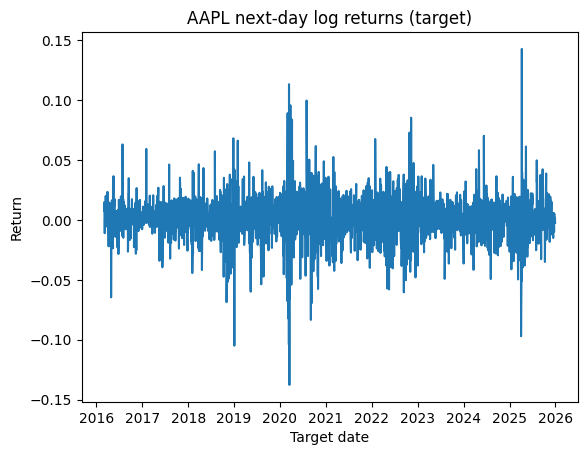

In [13]:
# Load processed data
panel = pd.read_parquet(PROC_DIR / "panel.parquet")

# 1) Check split coverage
print(panel.groupby(["Ticker", "split"]).size().unstack(fill_value=0))

# 2) Target must be later than feature date
bad_rows = (panel["target_date"] <= panel["Date"]).sum()
print("Rows where target_date <= Date (should be 0):", bad_rows)

# 3) Plot one ticker target series
one = panel[panel["Ticker"] == "AAPL"].sort_values("target_date")

plt.figure()
plt.plot(one["target_date"], one["target_ret"])
plt.title("AAPL next-day log returns (target)")
plt.xlabel("Target date")
plt.ylabel("Return")
plt.show()